<a id='step6'></a>

# <center>  Finding Donors for CharityML:</center>
<center>**(Supervised Learning)** </center>     

![Finding Donors](Description-Images/Finding-Donors.jpg)

#### [**0. Introduction**](#step0) 
#### [**I. Data Exploration**](#step1)
#### [**II. Data Preprocessing**](#step2) 
#### [**III. Models Training and Performance Evaluation**](#step3)
#### [**IV. Improving Results: Model Tuning**](#step4) 

<a id='step0'></a>

----------
# <font color='brown'>0. Introduction:</font>

In this project, We will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal of this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

<a id='step1'></a>

--------------------------------------------------------------
# <font color='brown'>I. Data Exploration</font>

By running The code cell below we will import necessary libraries, load and read the census data. 

The last column from this dataset, `'income'`, will be the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# print the possible values for the target 'income'
print data.income.unique()

['<=50K' '>50K']


In [3]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.loc[(data['income'] == '>50K')].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.loc[(data['income'] == '<=50K')].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/float(n_records) *100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

<a id='step2'></a>

-----------------------------

# <font color='brown'>II.  Data Preprocessing</font>
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

###  -  Transforming Skewed Continuous Features   
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below will plot a histogram of these two features. 

E:\Anaconda2\envs\DAND\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


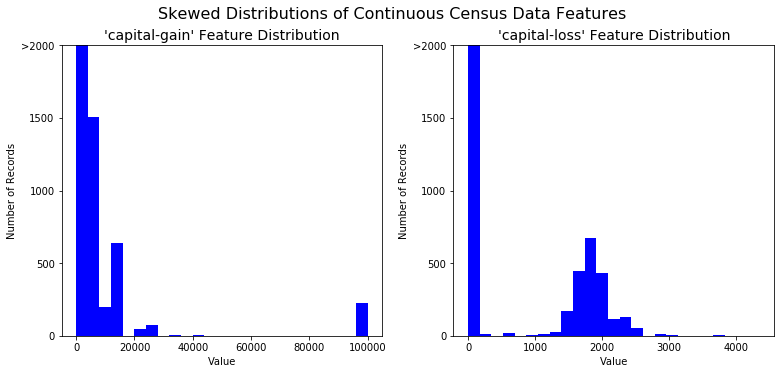

In [4]:
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = 'b')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot esthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

    
    
    
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. 

By running the code cell below we will perform a transformation on the data and visualize the results. 

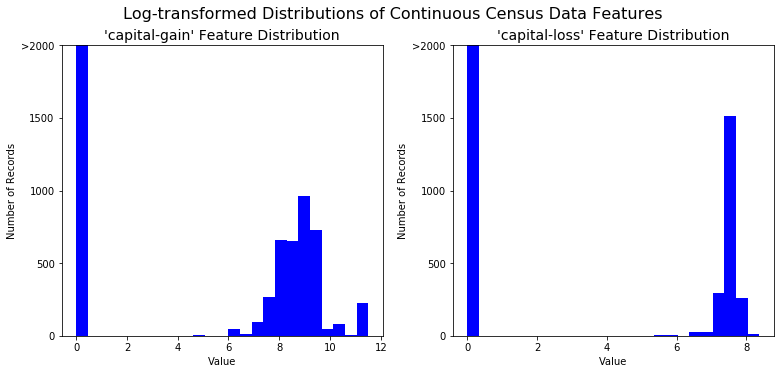

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(features_log_transformed, transformed = True)

### - Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners.

The code cell below will normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States


From the table in above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect inputs to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In code cell below, we will implement the following:
 - We wil use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - We will convert the target label `'income_raw'` to numerical entries.
 - We will set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = pd.get_dummies(data['income'])['>50K']

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

103 total features after one-hot encoding.


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
income = le.fit_transform(data['income'])
# print one hot
print income
# then we can reverse it with
print le.inverse_transform(income)

[0 0 0 ..., 0 0 1]
['<=50K' '<=50K' '<=50K' ..., '<=50K' '<=50K' '>50K']


## Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code cell below will perform this split.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 337)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


<a id='step3'></a>

----
# <font color='brown'>III. Evaluating Model Performance</font>

In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### - Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performance would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


### Accuracy, Precision and Recall:

### $ Accuracy=\frac{True Positives}{Total}$


### $ Precision=\frac{True Positives}{True Positives+ False Positives}$


### $ Sensitivity=\frac{True Positives} {True Positives + False Negatives}$


##  Naive Predictor Performance

If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally a base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

In [10]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# True Positives
TP = np.sum(income)

# False Positives
FP = len(income) - TP

# True negatives
TN=0

# False negatives
FN=0

# f-score coefficient
Beta=0.5

# accuracy, precision and recall
accuracy = TP/float(len(income))

recall = TP/float(TP+FN)

precision = TP/float(TP+FP)

#  F-score with beta = 0.5 
fscore = (1+ Beta*Beta)*precision*recall/(Beta*Beta * precision  + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore) 

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


##  Supervised Learning Models

### Model Application
Now we'll pick three supervised learning algorithms that are appropriate for this problem, and test them on the census data. 

* **The chosen algorithms are :**
    - **A** Decision Tree Classifier
    - **B** Logistic regression Classifier
    - **C** Adaboost

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important to create a training and predicting pipeline that allows to train models quickly and effectively using various sizes of training data and perform predictions on the testing data. 

In [11]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import fbeta_score 

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
        
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train =learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] =end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] =fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation


In [12]:
#  Importing the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initializingthe three models

# Decision Tree classifier
clf_A = DecisionTreeClassifier( random_state=48)

# Logisitic Regression classifier
clf_B =LogisticRegression( random_state=48)

# Gradient Boosting
clf_C= AdaBoostClassifier(random_state=48)

# Calculating the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(X_train))
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)




DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


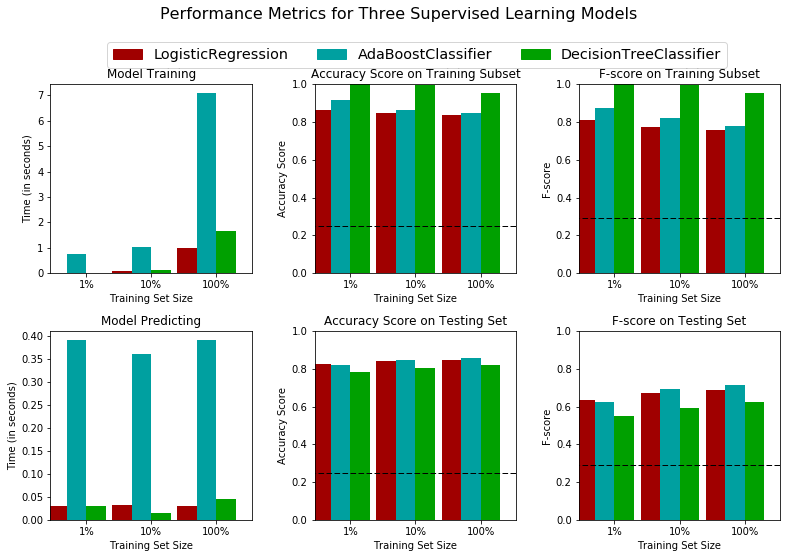

In [13]:
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.patches as mpatches
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

### - Visualization Values

In [14]:
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1% of train', 1:'10% of train', 2:'100% of train'}))

LogisticRegression


,1% of train,10% of train,100% of train
acc_test,0.823328,0.840022,0.845661
acc_train,0.866667,0.846667,0.836667
f_test,0.635615,0.672991,0.688720
f_train,0.811856,0.773196,0.760870
pred_time,0.031000,0.032000,0.031000
train_time,0.000000,0.093000,0.974000


AdaBoostClassifier


,1% of train,10% of train,100% of train
acc_test,0.818463,0.848203,0.856164
acc_train,0.916667,0.866667,0.846667
f_test,0.624590,0.691686,0.715893
f_train,0.875000,0.819892,0.779570
pred_time,0.390000,0.360000,0.391000
train_time,0.740000,1.032000,7.082000


DecisionTreeClassifier


,1% of train,10% of train,100% of train
acc_test,0.781316,0.801990,0.818242
acc_train,1.000000,0.996667,0.953333
f_test,0.551442,0.593306,0.624130
f_train,1.000000,0.997807,0.952381
pred_time,0.031000,0.015000,0.046000
train_time,0.016000,0.109000,1.668000


### - Choosing the Best Model

Based on the evaluation performed above it appears that Adaboost model has the highest F1 score in testing phase when 100%  of training data is achieved. 

Adaboost  is approriate for the data since all requirements of its default base learner `'Decision Tree'` were statisfied :
    
- There is enough data to train the base learner. 
- Computational scalability not only for the weak learner but also for adaboost algorithm
- The ability to deal with irrelevant features. As we will see later  5 features explains more than 70% of variability in the data the rest of 98 features are less important or irrelevent. Despite that huge number of irrelevent features Adaboost and decision trees as its weak learner are doing well in testing.

### Adaboost in Layman's Terms:

1. Adaboost works by combining several simple learners (for ex: decision trees), to create an ensemble of learners that can predict whether an individual earns above 50k or not.

2. Each of the learners, in our case decision trees, are created using "features" we have about individuals (eg. age, occupation, education, etc) create a set of rules that can predict a person's income. 

3. During the training process, which lasts for several rounds, the Adaboost algorithm looks at instances where it has predicted badly, and prioritizes the correct prediction of those instances in the next round of raining.

4. With each round, the model finds the best learner (or decision tree) to incorporate into the ensemble, repeating the process for the specified number of rounds, or till we can't improve the predictions further.

5. All the learners are then combined to make a final ensembled model, where they each vote to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

6. Using this model with the census information of individuals, we can predict the same information for a potential new donor and predict if they earn more than 50K or not, and thus make a decision on the likeliness of them donating to charity.

<a id='step4'></a>

-----
# <font color='brown'>IV. Improving Results: Model Tuning </font>

In this final section we will tune parameters of adaboost using grid search (`GridSearchCV`).

In the code cell below, we will implement the following:

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).

- Initializing the chosen classifier and store it in `clf`.
- Creating a dictionary of parameters we wish to tune for the chosen model.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [15]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Initialize the classifier
clf = AdaBoostClassifier(random_state=48)
            

# Create the parameters list

parameters = { 'n_estimators':[50,100,200] ,          
               'algorithm':['SAMME', 'SAMME.R'], 
            }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=48)


In [16]:
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8562
F-score on testing data: 0.7159

Optimized Model
------
Final accuracy score on the testing data: 0.8641
Final F-score on the testing data: 0.7323


### - Final Model Evaluation


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8483            |  0.8651         |
| F-score        | 0.7029            |   0.7396        |




The optimized model has an accuracy of 0.8651 and F-score of 0.7396. 

These scores are better than the umpotimized model, while being substantially better than the benchmark predictor.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### - Feature Relevance Observation
We know that there are thirteen available features for each individual on record in the census data.  Of these thirteen records, we can guess which five features might be most important for prediction. Let's give that a go.

In my opinion these are the most important features for a good prediction :

- 1) **'capital-gain'** is strongly correlated with the income.
- 2) **'capital-loss'** is strongly correlated with the income.

Sine these two columns will have great impact on the income.

- 3) **'Education-num'** The level of education is important to determine the income.

- 4) **Age** is correlated with years of experience which means a high salary. 

- 5) **'hours-per-week'**  is important : if a person works for full time or a part time in a job this may have an impact on the income. 


### - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [17]:
# Import a supervised learning model that has 'feature_importances_'

clf=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=48)

start=time()

# Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train,y_train)

predictions = model.predict(X_test)

end=time()

full_duration=end-start

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

In [18]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

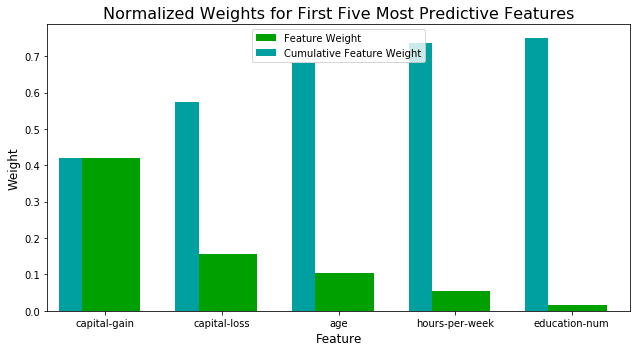

In [19]:
# Plot
feature_plot(importances, X_train, y_train)

Adaboost algorithm gives the capital gain and capital loss more weights systematically they will give us a clear idea about the income. The visualization shows that the sum of weights of these two features represents more 60% of cumulative weights of all the 103 feature.I was expecting the education num to will have more importance than age but i was wrong.It appears that the number of years of experience is more important than the Education Level.  

### Feature Selection
An interesting question here is, how does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

Let's see how a model that is trained only on the selected features, performs.

In [20]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start=time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)
end=time()
reduced_duration= end - start
# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data duration\n------"
print "training and predicting duration for reduced data in seconds:{:.4f}".format(reduced_duration)
print "\nFinal Model trained on full data duration\n------"
print "training and predicting duration for full data in seconds:{:.4f}".format(full_duration) 

Final Model trained on full data
------
Accuracy on testing data: 0.8641
F-score on testing data: 0.7323

Final Model trained on reduced data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6929

Final Model trained on reduced data duration
------
training and predicting duration for reduced data in seconds:13.2310

Final Model trained on full data duration
------
training and predicting duration for full data in seconds:34.9280


### - Effects of Feature Selection

On the reduced dataset, the final model's accuracy and f-score are still very comparable to the results on the full dataset. 

The scores of the full data are little higher than the reduced one this is normal since the deleted features in reduced data have also an impact in the model.

If the training time was an important factor i would choose to work with reduced data for two reasons: 

- 1) It would reduce training and prediction time less than 11 seconds compared to 29 seconds.This will play an important role when use slow classifiers or gridseachCV with an important number of parameters to optimize. 

- 2) The reduced data doesn't have a great impact on the scores.

[**Go back to the beginning**](#step6)

###### This project was completed as a part of the **Machine Learning Engineer Nanodegree** from Udacity.